In [7]:

import torch
import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset

import librosa
import librosa.display
import numba.decorators
import numpy as np
import matplotlib.pyplot as plt
from numba.decorators import jit as optional_jit


from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')


#PATH = 'C://Projects//keras_talk//keras//intern//dataset//'
PATH = '/content/gdrive/My Drive/dataset/'

train_size = 800
test_size = 200

EPOCHS = 3
BATCH_SIZE = 50


def Y_DATA(y_data):
    for idx in range(y_data.shape[0]):
        y = y_data[idx]
        if y < 0:  y_data[idx] = 10
        else:      y_data[idx] = (y//20)
    return y_data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:

import numpy as np


dataset_dict = { 0 : 'S_left',        1 : 'S_left_phase',
                 2 : 'S_right',       3 : 'S_right_phase',
                 4 : 'clean_left',    5 : 'clean_left_phase',
                 6 : 'clean_right',   7 : 'clean_right_phase',
                 8 : 'idx_drone_end', 9 : 'idx_voice_end',
                10 : 'idx_voice_start'}



numpy_dict = dict()
for n in range(4):
    numpy_name    = dataset_dict[n]
    numpy_dict[n] = np.load( PATH + numpy_name + '.npy' )
    


'''    x_data,       y_data '''
'''(1000,4,257,382), (1000,)'''

x_data = []
for idx in range(1000):
    x_element = []

    for n in range(4):
        x_element.append( numpy_dict[n][:,:,idx] )

    x_element = np.asarray( x_element )
    
    #log scale 변환
    x_log = np.log10( np.abs(x_element) +1 )
    x_data.append( x_element )


x_data = np.asarray(x_data)
y_data = Y_DATA( np.load(PATH + 'angle.npy') )
print('done..')

done..


#### audio_000200.wav  
######    sampling rate : 16k Hz
######    NFFT : 512
######    hop_length : 250 (array 크기를 257*382 로 맞추기 위해서 250으로 했습니다.)

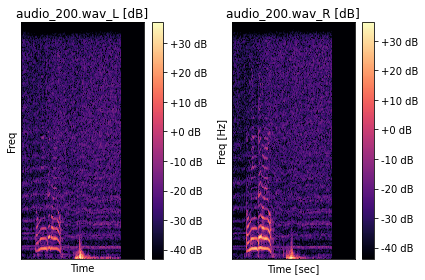

In [4]:

import librosa.display

file_path = '/content/gdrive/My Drive/'
#file_path = 'C:/Users/DongHwi/Desktop/intern/'
file = 'audio_000200.wav'

NFFT = 512
Freq = 16000

y, sr = librosa.load(file_path+file, sr=16000, mono=False)

L = y[0]
R = y[1]



# 6 seconds
# zero padding 
zeros = [0]*(Freq*6 - L.shape[0])



L = np.append(L, np.asarray(zeros))
R = np.append(R, np.asarray(zeros))

stft_L = librosa.stft(np.asfortranarray(L), n_fft=NFFT, hop_length=250, center=False )
stft_R = librosa.stft(np.asfortranarray(R), n_fft=NFFT, hop_length=250, center=False )


mag_L, phase_L = librosa.magphase(stft_L)
mag_R, phase_R = librosa.magphase(stft_R)


log_spectrogram_L = librosa.amplitude_to_db(mag_L)
log_spectrogram_R = librosa.amplitude_to_db(mag_R)


plt.figure()

plt.subplot(121)
librosa.display.specshow(log_spectrogram_L, sr=Freq, hop_length=250)
plt.xlabel('Time')
plt.ylabel('Freq')
plt.colorbar(format="%+2.0f dB")
plt.title('audio_200.wav_L [dB]')

plt.subplot(122)
librosa.display.specshow(log_spectrogram_R, sr=Freq, hop_length=250)
plt.xlabel('Time [sec]')
plt.ylabel('Freq [Hz]')
plt.colorbar(format="%+2.0f dB")
plt.title('audio_200.wav_R [dB]')
plt.tight_layout()
plt.show()


#### dataset.mat 의 200번째 magnitude spectrogram

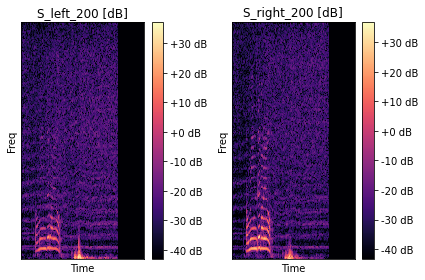

In [5]:

x_data_200_L = librosa.amplitude_to_db(x_data[199][0])
x_data_200_R = librosa.amplitude_to_db(x_data[199][2])


plt.figure()

plt.subplot(121)
librosa.display.specshow(x_data_200_L, sr=Freq, hop_length=250)
plt.xlabel('Time')
plt.ylabel('Freq')
plt.colorbar(format="%+2.0f dB")
plt.title('S_left_200 [dB]')

plt.subplot(122)
librosa.display.specshow(x_data_200_R, sr=Freq, hop_length=250)
plt.xlabel('Time')
plt.ylabel('Freq')
plt.colorbar(format="%+2.0f dB")
plt.title('S_right_200 [dB]')
plt.tight_layout()
plt.show()

In [9]:

#x_data = x_data.reshape()
#y_data = y_data.reshape()


x_data = torch.from_numpy( x_data ).float().to('cuda')
y_data = torch.from_numpy( y_data ).long().to('cuda')

full_dataset = TensorDataset( x_data, y_data )


train_dataset, valid_dataset = torch.utils.data.random_split( full_dataset, [train_size, test_size])
train_dataset = DataLoader( dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataset = DataLoader( dataset=valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)


In [10]:
import torch.nn as nn
import torch.nn.functional as F


class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 4 * 257 * 382
        self.conv1 = nn.Conv2d( in_channels= 4, out_channels= 64, kernel_size = (10,11) )
        # 64 * 124 * 186
        self.conv2 = nn.Conv2d( in_channels=64, out_channels=128, kernel_size = (11,11) )
        # 128 * 57 * 88
        self.lay1  = nn.Linear( 128*57*88, 256 )
        self.lay2  = nn.Linear( 256, 256 )
        self.lay3  = nn.Linear( 256, 64 )
        self.lay4  = nn.Linear( 64 , 11 )
        
        
        
    def forward(self, output):
        output = F.max_pool2d( F.relu( self.conv1(output) ),2 )
        output = F.max_pool2d( F.relu( self.conv2(output) ),2 )
        output = output.view(-1, 128*57*88)
        output = F.relu( self.lay1(output) )
        output = F.dropout(output, training=self.training)
        output = F.relu( self.lay2(output) )
        output = F.dropout(output, training=self.training)
        output = F.relu( self.lay3(output) )
        output = F.dropout(output, training=self.training)
        output = F.log_softmax(self.lay4(output), dim=1)
        
        return output
    

In [11]:
torch.manual_seed(1)

model = CNN().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

train_loss = []
train_acc  = []


model.train()
for epoch in range(EPOCHS):
    print('epoch' + str(epoch+1))
    
    for i, (data, label) in enumerate(train_dataset):
        (data, label) = (data.to('cuda'), label.to('cuda'))

        optimizer.zero_grad()
        output = model(data)
  
        loss = F.nll_loss(output, label.reshape(BATCH_SIZE))
        loss.backward()
        optimizer.step()
        
        preds = output.data.max(1)[1]
        corr  = (preds==label.reshape(BATCH_SIZE)).sum().item()
        acc   = corr/BATCH_SIZE*100
        
        train_loss.append(loss.item())
        train_acc.append( acc )
        
        print('\tLoss: {:.3f}\tAcc: {:.3f}'.format(loss.item(), acc))
        

epoch1
	Loss: 2.400	Acc: 6.000
	Loss: 2.444	Acc: 12.000
	Loss: 2.529	Acc: 14.000
	Loss: 2.590	Acc: 4.000
	Loss: 2.390	Acc: 8.000
	Loss: 2.437	Acc: 2.000
	Loss: 2.472	Acc: 6.000
	Loss: 2.458	Acc: 8.000
	Loss: 2.463	Acc: 10.000
	Loss: 2.423	Acc: 20.000
	Loss: 2.462	Acc: 8.000
	Loss: 2.387	Acc: 8.000
	Loss: 2.397	Acc: 10.000
	Loss: 2.415	Acc: 6.000
	Loss: 2.399	Acc: 8.000
	Loss: 2.399	Acc: 4.000
epoch2
	Loss: 2.419	Acc: 6.000
	Loss: 2.392	Acc: 8.000
	Loss: 2.411	Acc: 6.000
	Loss: 2.419	Acc: 12.000
	Loss: 2.407	Acc: 10.000
	Loss: 2.402	Acc: 4.000
	Loss: 2.404	Acc: 8.000
	Loss: 2.407	Acc: 12.000
	Loss: 2.404	Acc: 14.000
	Loss: 2.412	Acc: 4.000
	Loss: 2.399	Acc: 12.000
	Loss: 2.398	Acc: 10.000
	Loss: 2.384	Acc: 8.000
	Loss: 2.396	Acc: 8.000
	Loss: 2.395	Acc: 8.000
	Loss: 2.395	Acc: 16.000
epoch3
	Loss: 2.402	Acc: 6.000
	Loss: 2.399	Acc: 10.000
	Loss: 2.403	Acc: 4.000
	Loss: 2.394	Acc: 12.000
	Loss: 2.386	Acc: 4.000
	Loss: 2.410	Acc: 10.000
	Loss: 2.406	Acc: 6.000
	Loss: 2.401	Acc: 12.000
	Lo